In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchaudio

In [ ]:
import pandas as pd
import os
import numpy as np
import pickle
import librosa
import torchaudio
import matplotlib.pyplot as plt 

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.metrics import f1_score
from sklearn.svm import SVC


from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import BatchNormalization

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# get train and test data
path = "/content/drive/MyDrive/Colab Notebooks/project/"
with open (path +"pickle/train_data.plk",'rb')  as f:
    train= pickle.load(f)
with open (path +"pickle/test_data.plk",'rb')  as f:
    test= pickle.load(f)

Data Preprocessing 


In [ ]:
#set data to np array 
x_train = np.array(train.features.tolist())
y_train = np.array(train.label.tolist())
x_test = np.array(test.features.tolist())
y_test = np.array(test.label.tolist())

x_test= x_test.reshape(x_test.shape[0],x_test.shape[2])
x_train= x_train.reshape(x_train.shape[0],x_train.shape[2])

# Data standardization
x_train = scale(x_train)
x_test = scale(x_test)


In [ ]:
# Oversampling using SMOKE
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)
counter = Counter(y_train)

# label encode
lb = LabelEncoder()
y_train =np_utils.to_categorical(lb.fit_transform(y_train))
y_test =np_utils.to_categorical(lb.fit_transform(y_test))

#splite train data to train set and val set 
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    random_state=42,
    shuffle=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
print(counter)

Counter({'Hi-hat': 300, 'Saxophone': 300, 'Trumpet': 300, 'Glockenspiel': 300, 'Cello': 300, 'Knock': 300, 'Gunshot_or_gunfire': 300, 'Clarinet': 300, 'Computer_keyboard': 300, 'Keys_jangling': 300, 'Snare_drum': 300, 'Writing': 300, 'Laughter': 300, 'Tearing': 300, 'Fart': 300, 'Oboe': 300, 'Flute': 300, 'Cough': 300, 'Telephone': 300, 'Bark': 300, 'Chime': 300, 'Bass_drum': 300, 'Bus': 300, 'Squeak': 300, 'Scissors': 300, 'Harmonica': 300, 'Gong': 300, 'Microwave_oven': 300, 'Burping_or_eructation': 300, 'Double_bass': 300, 'Shatter': 300, 'Fireworks': 300, 'Tambourine': 300, 'Cowbell': 300, 'Electric_piano': 300, 'Meow': 300, 'Drawer_open_or_close': 300, 'Applause': 300, 'Acoustic_guitar': 300, 'Violin_or_fiddle': 300, 'Finger_snapping': 300})


Evaluation Function 

In [ ]:
# f1_score 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Build CNN model 

In [ ]:
def CNN(x_train, y_train, x_val, y_val):
    x_train = np.expand_dims(x_train, axis=-1)
    x_val = np.expand_dims(x_val, axis=-1)

    x_train = x_train.astype(float)
    x_val = x_val.astype(float)

    #Set the input and output sizes
    input_size = x_train.shape[1] 
    output_size = y_train.shape[1] 

    def create_model(batch_size = 128, optimizer = 'Adam' ,dropout_rate=0.4,neurons=250,activation='relu', kernel = 3, filters = 500):

        model = Sequential()
        model.add(Conv1D(1000,
                     input_size,
                     padding='valid',
                     activation=activation,
                     strides=3))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(output_size, activation='softmax'))
        model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = [F1_score])
        return model

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights =True)
  

    model = KerasClassifier(build_fn=create_model)

    history = model.fit(x_train, 
              y_train, 
              batch_size=128, 
              epochs=100, 
              callbacks=[early_stopping], # early stopping
              validation_data=(x_val, y_val), # validation data
              verbose = 2 
              )


    return history

In [ ]:
cnn= CNN(x_train, y_train, x_val, y_val)

Epoch 1/100
77/77 - 3s - loss: 2.8126 - F1_score: 0.2514 - val_loss: 3.4022 - val_F1_score: 0.0000e+00
Epoch 2/100
77/77 - 1s - loss: 2.1106 - F1_score: 0.3998 - val_loss: 3.1564 - val_F1_score: 0.0000e+00
Epoch 3/100
77/77 - 1s - loss: 1.8395 - F1_score: 0.4762 - val_loss: 2.8063 - val_F1_score: 0.0031
Epoch 4/100
77/77 - 1s - loss: 1.6290 - F1_score: 0.5292 - val_loss: 2.2848 - val_F1_score: 0.0675
Epoch 5/100
77/77 - 1s - loss: 1.5179 - F1_score: 0.5522 - val_loss: 1.8158 - val_F1_score: 0.2919
Epoch 6/100
77/77 - 1s - loss: 1.4174 - F1_score: 0.5867 - val_loss: 1.4904 - val_F1_score: 0.4788
Epoch 7/100
77/77 - 1s - loss: 1.3166 - F1_score: 0.6105 - val_loss: 1.3000 - val_F1_score: 0.5959
Epoch 8/100
77/77 - 1s - loss: 1.2491 - F1_score: 0.6273 - val_loss: 1.2304 - val_F1_score: 0.6411
Epoch 9/100
77/77 - 1s - loss: 1.1941 - F1_score: 0.6466 - val_loss: 1.1756 - val_F1_score: 0.6648
Epoch 10/100
77/77 - 1s - loss: 1.1341 - F1_score: 0.6633 - val_loss: 1.1711 - val_F1_score: 0.6809
E

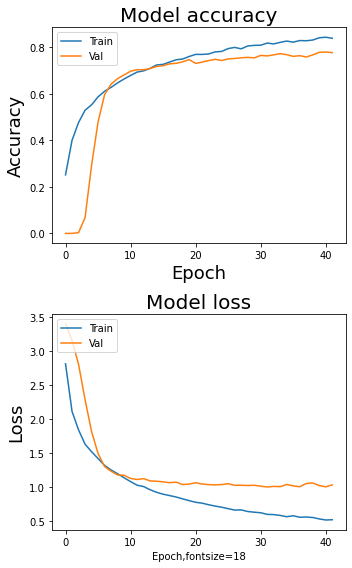

In [ ]:


def plotNetwork(history, return_fig=True):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 8))
    ax1.plot(history.history['F1_score'])
    ax1.plot(history.history['val_F1_score'])
    ax1.set_title('Model accuracy', fontsize=20)
    ax1.set_xlabel('Epoch',fontsize=18)
    ax1.set_ylabel('Accuracy',fontsize=18)
    ax1.legend(['Train', 'Val'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss',fontsize=20)
    ax2.set_xlabel('Epoch,fontsize=18')
    ax2.set_ylabel('Loss',fontsize=18)
    ax2.legend(['Train', 'Val'], loc='upper left')

     
    fig.tight_layout()
    if return_fig:
                return fig
fig =plotNetwork(cnn, return_fig=True)
fig.savefig(path + "fig/CNN.png")



In [ ]:
def mlp(x_train, y_train, x_test, y_test):
    n_input = len(x_train[1])
    n_hidden_1 = 200
    n_hidden_2 = 200
    n_classes = 41

    inputs = tf.keras.Input(shape=(n_input,))

    print(inputs.shape)

    x = tf.keras.layers.Dense(n_hidden_1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(n_hidden_2, activation='relu')(x)
    predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)

    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=[F1_score])

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights =True)

    history = model.fit(x_train,
              y_train, 
              batch_size=64, 
              epochs=100, 
              callbacks=[early_stopping],           
              validation_data=(x_test, y_test), 
              verbose = 2 
              )
    return history

In [ ]:
mlp = mlp(x_train, y_train, x_val, y_val)

(None, 68)
Epoch 1/100
154/154 - 1s - loss: 2.4368 - F1_score: 0.1685 - val_loss: 1.8853 - val_F1_score: 0.3735
Epoch 2/100
154/154 - 1s - loss: 1.6594 - F1_score: 0.4615 - val_loss: 1.6066 - val_F1_score: 0.5048
Epoch 3/100
154/154 - 1s - loss: 1.3866 - F1_score: 0.5694 - val_loss: 1.4894 - val_F1_score: 0.5528
Epoch 4/100
154/154 - 1s - loss: 1.2220 - F1_score: 0.6305 - val_loss: 1.3866 - val_F1_score: 0.6053
Epoch 5/100
154/154 - 1s - loss: 1.0765 - F1_score: 0.6757 - val_loss: 1.3319 - val_F1_score: 0.6309
Epoch 6/100
154/154 - 1s - loss: 0.9685 - F1_score: 0.7119 - val_loss: 1.3141 - val_F1_score: 0.6452
Epoch 7/100
154/154 - 1s - loss: 0.8726 - F1_score: 0.7423 - val_loss: 1.2440 - val_F1_score: 0.6766
Epoch 8/100
154/154 - 1s - loss: 0.7893 - F1_score: 0.7710 - val_loss: 1.2467 - val_F1_score: 0.6816
Epoch 9/100
154/154 - 0s - loss: 0.7162 - F1_score: 0.7917 - val_loss: 1.2160 - val_F1_score: 0.6935
Epoch 10/100
154/154 - 1s - loss: 0.6502 - F1_score: 0.8129 - val_loss: 1.2281 -

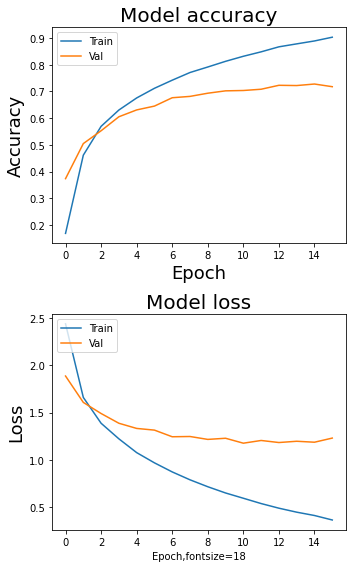

In [ ]:
fig =plotNetwork(mlp, return_fig=True)
fig.savefig(path + "fig/MLP.png")

In [ ]:
def cnn(x_train, y_train, x_test, y_test):
    x_train = x_train.reshape(x_train.shape[0],17,2,2)
    x_test = x_test.reshape(x_test.shape[0],17,2,2)

    inputs = tf.keras.Input(shape=(17,2,2))

    x = tf.keras.layers.Conv2D(17, kernel_size=2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1, 1))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1, 1))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1, 1))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    predictions = tf.keras.layers.Dense(41, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)

    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=[F1_score])

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights =True)

    history = model.fit(x_train,
              y_train, 
              batch_size=128, 
              epochs=100, 
              callbacks=[early_stopping],           
              validation_data=(x_test, y_test), 
              verbose = 2 
              )
    return history

In [ ]:
 c = cnn(x_train, y_train, x_val, y_val)

Epoch 1/100
77/77 - 4s - loss: 2.6569 - F1_score: 0.1661 - val_loss: 2.7302 - val_F1_score: 0.0065
Epoch 2/100
77/77 - 3s - loss: 1.9320 - F1_score: 0.3733 - val_loss: 2.1531 - val_F1_score: 0.1788
Epoch 3/100
77/77 - 3s - loss: 1.7349 - F1_score: 0.4486 - val_loss: 1.7499 - val_F1_score: 0.4290
Epoch 4/100
77/77 - 3s - loss: 1.5897 - F1_score: 0.5013 - val_loss: 1.5110 - val_F1_score: 0.5427
Epoch 5/100
77/77 - 3s - loss: 1.4778 - F1_score: 0.5358 - val_loss: 1.3906 - val_F1_score: 0.5909
Epoch 6/100
77/77 - 3s - loss: 1.3701 - F1_score: 0.5672 - val_loss: 1.3003 - val_F1_score: 0.6283
Epoch 7/100
77/77 - 3s - loss: 1.3125 - F1_score: 0.5940 - val_loss: 1.2739 - val_F1_score: 0.6402
Epoch 8/100
77/77 - 3s - loss: 1.2399 - F1_score: 0.6102 - val_loss: 1.2328 - val_F1_score: 0.6612
Epoch 9/100
77/77 - 3s - loss: 1.1795 - F1_score: 0.6301 - val_loss: 1.2308 - val_F1_score: 0.6704
Epoch 10/100
77/77 - 3s - loss: 1.1250 - F1_score: 0.6528 - val_loss: 1.1988 - val_F1_score: 0.6735
Epoch 11/

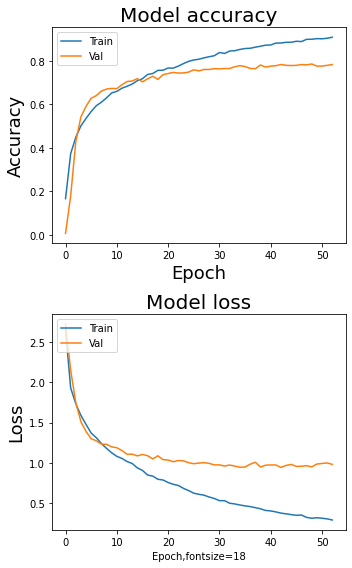

In [ ]:
fig =plotNetwork(c, return_fig=True)
fig.savefig(path + "fig/2D-conv_CNN.png")